<a href="https://www.kaggle.com/mikayil/binary-classification-with-lgbm-optuna-gpu?scriptVersionId=88490549" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Task Description

We are interested in identifying subscribers that determine the multisim behavior in order to be able to plan how to increase the consumption of services within the our mobile network.

The multisimmer is a customer who uses multiple operators' services simultaneously.

You are provided with multisimmer.parquet data file and on top of it you are required to build a classification type of ML model that will provide probability assumptions about customers' multisim usage behavior. Probability threshold must be 0.5.

Due to the confidentiality issues the provided subscriber ids and some column names are masked.

Masked column names are specified as follows: var1, var2 … .

Description of non-masked columns:
* subscriber_id: unique id number of each subscriber
* trf: label encoded name of subscriber activated tariff
* age: subscriber age in years
* gndr: subscriber gender: M – for mail, F – for female, U – for unknown
* tenure: subscriber tenure in days
* dev_man: manufactor name of subscriber’s device
* device_os_name: manufacture OS type of subscriber’s device
* is_dualsim: 1 - if device support dulasim option, 0 - if not
* is_featurephone: 1 - if device is a feature phone type, 0 - if not
* is_smartphone: 1 - if device is a smartphone type, 0 - if not
* simcard_type: technology type of simcard
* region: label encoded name of subscriber region
* is_bundel_trf: 1 - if current tariff of subscriber is bundle type, 0 - if not
* target: 1 - if subscriber is a multisimmer, 0 - if subscriber consumes only our services
* Train test split must be in 70/30 proportion.

Required steps to be completed:
*     EDA
*     Data cleaning
*     Data preprocessing
*     Comparison of models
*     Hyperparameter tuning
*     Visualization 


# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import seaborn as sns
from sklearn import preprocessing
import re
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, accuracy_score, roc_curve

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
import optuna

import warnings 

warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

%matplotlib inline

# Reading Data

In [2]:
data = pd.read_parquet('../input/multisim/multisimmers.parquet')

print(f'\033[92mNumber of rows in data: {data.shape[0]}')
print(f'\033[94mNumber of columns in data: {data.shape[1]}')
print(f'\033[91mNumber of values in data: {data.count().sum()}')
print(f'\033[91mNumber missing values in data: {sum(data.isna().sum())}')

Number of rows in data: 52835
Number of columns in data: 212
Number of values in data: 11140911
Number missing values in data: 60109


In [3]:
subset = data.columns.difference(['subscriber_id','age', 'gndr'])
print(len(data))
# Checking if there is any duplicates in data subset excluding id, age and gender
data = data.drop_duplicates(subset=subset)
print(len(data))

52835
52835


In [4]:
data.dropna(thresh=data.shape[1] - 2, inplace=True)
# Deleting rows that have at least 2 NaN values
print(len(data))

52614


# Dealing with missing values

In [5]:
def percent_missing_df(data:pd.DataFrame) -> pd.DataFrame:
    """ Calculates percent of missing values in all columns of DataFrame
    Arguments:
        data: pd.DataFrame
    Returns:
        The DataFrame with results of calculation
    """
    percent_missing= data.isnull().sum() * 100 / len(data)
    missing_value_df = pd.DataFrame({'column_name': data.columns,
                                     'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', ascending = False , inplace=True)
    return missing_value_df

In [6]:
percent_missing_df(data)

,column_name,percent_missing
var_75,var_75,98.673357
var_133,var_133,6.656023
simcard_type,simcard_type,6.654122
var_76,var_76,0.695632
age,age,0.199567
...,...,...
var_78,var_78,0.000000
var_79,var_79,0.000000
var_80,var_80,0.000000
var_81,var_81,0.000000


In [7]:
# var_75 column has too many NaN values so I decided to drop it
data.drop('var_75', axis=1, inplace=True)

In [8]:
data.simcard_type.fillna('2G', inplace=True)
# We will assume that missing values in simcard_type is for the 2G network because collected data doesn't contain "2G".
# Even if these NaN values aren't 2G, it's good practice to treat missing data as another category.

In [9]:
data.age.value_counts()
# here we can see unvalid data like 1960, 1961

40      1513
41      1494
44      1444
38      1433
39      1429
        ... 
1951       1
92         1
1960       1
1958       1
363        1
Name: age, Length: 92, dtype: int64

In [10]:
data.age.fillna(0, inplace= True)
# temporarily filling NaN values with 0 

data.age = data.age.astype('int32')
# converting age column from object datatype to integer

data.loc[data.age > 1900, 'age'] = 2021 - data.loc[data.age > 1900, 'age'].values
# replacing all ages that were messed up with a year

data.loc[data.age > 100, 'age'] = 0
# also reassigning this values to zero, because they are rare and can be outliers that will damage our model 

data.loc[data.age == 0, 'age'] = int(data.age.mean())
#filling zero values with mean value that equals to 44

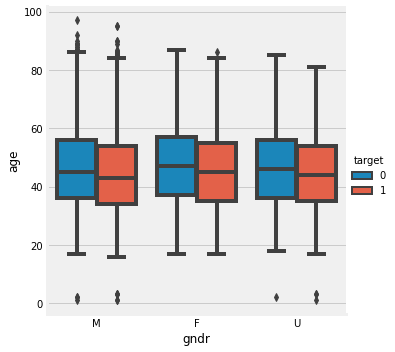

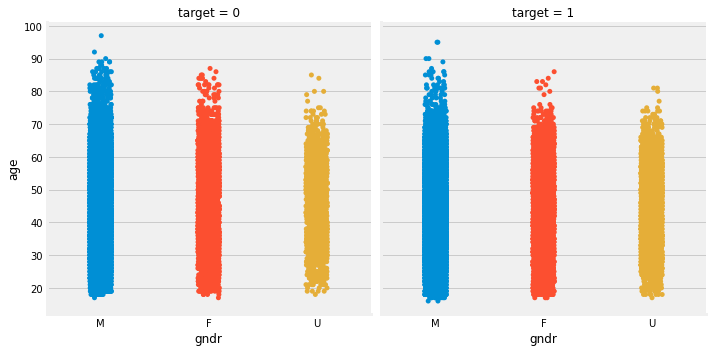

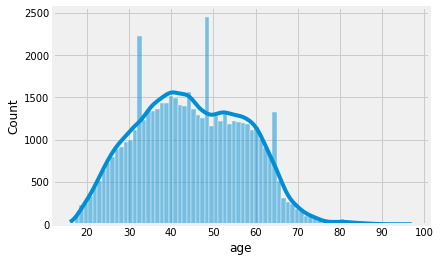

In [11]:
sns.catplot(x ='gndr', y ='age', 
               hue = 'target', data = data, kind="box")
plt.show()
# Plot displays the five-number summary of a set of data.
# The five-number summary is the minimum, first quartile, median, third quartile, and maximum
# we can see that there is data point with unvalid age, so I changed it to mean value
data.loc[data.age < 16, 'age'] = int(data.age.mean())
sns.catplot(x ='gndr', y ='age',
                col="target", data=data)
plt.show()

sns.histplot(x=data["age"], fill =True , kde = True)
plt.show()




In [12]:
data.var_133.value_counts()
# this column also have very little valuable data

0.0     49098
1.0         7
3.0         3
4.0         2
15.0        1
2.0         1
Name: var_133, dtype: int64

In [13]:
data.drop('var_133', axis=1, inplace=True)

In [14]:
data.var_76.value_counts()

0.5      770
1.5      739
1.6      704
0.6      653
0.2      620
        ... 
105.7      1
96.7       1
110.3      1
75.8       1
53.9       1
Name: var_76, Length: 1473, dtype: int64

<AxesSubplot:>

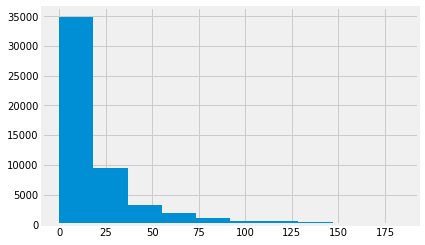

In [15]:
data.var_76.hist()

In [16]:
data.var_76.fillna(data.var_76.mode()[0], inplace=True)
# Best filling with this type of distribution is mode, 
# because we don't affect data like it happens if we fill by mean values

In [17]:
data.dev_man.fillna('Other',inplace=True)
other_devs = list(data.dev_man.value_counts(normalize=True).loc[lambda x: x<=0.001].index)
# I filtered and from 167 unique devs got 24 most frequent, remaining values i grouped into 'Other' variable

In [18]:
data.dev_man.replace(other_devs, 'Other', inplace=True)
data.dev_man.value_counts()

Samsung                    26825
Xiaomi                     12893
Nokia                       2558
Hmd Global Oy               2307
Apple                       2301
Huawei                      2022
Other                       1042
Hedy                         411
Microsoft Mobile             385
LG                           303
Ut Group Limited             239
F-Plus                       162
TCL                          149
Fly Mobiles                  142
Lenovo                       123
Realme                       109
High Tech Computer            98
ZTE                           85
Tecno Telecom                 76
Micromax                      71
Hongkong IPRO                 68
Itel Technology Limited       66
Sony                          64
Meizu                         59
Hisense                       56
Name: dev_man, dtype: int64

In [19]:
data.device_os_name.fillna('Proprietary',inplace=True)

In [20]:
data[data.tenure.isna()]
# we have only one value in tenure column, we can fill it with mean values

,subscriber_id,trf,age,gndr,tenure,var_5,dev_man,device_os_name,var_8,is_dualsim,...,var_202,var_203,var_204,var_205,var_206,var_207,var_208,var_209,var_210,is_bundle_trf
7245,6961525674895,2,66,M,NaN,704,Samsung,Android OS,1,1,...,0,0,0.0,0.0,0,0,0.0,0,0,0


In [21]:
data.tenure.fillna(data.tenure.mean(),inplace=True)

In [22]:
data[data.var_74.isna()]

,subscriber_id,trf,age,gndr,tenure,var_5,dev_man,device_os_name,var_8,is_dualsim,...,var_202,var_203,var_204,var_205,var_206,var_207,var_208,var_209,var_210,is_bundle_trf
1101,6961606270571,0,41,F,3857.0,1004,Xiaomi,Android OS,1,1,...,0,0,0.0,0.0,0,0,0.0,0,0,0
12536,6961556105358,9,31,M,1044.0,120,Hmd Global Oy,Proprietary,1,1,...,0,0,0.0,0.0,0,0,0.0,0,0,0


<AxesSubplot:ylabel='Frequency'>

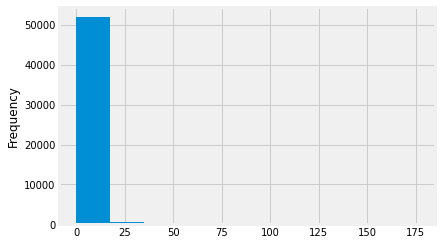

In [23]:
data.var_74.plot(kind='hist')

In [24]:
data.var_74.value_counts()

0.0     23785
0.1      7401
0.2      6185
0.3      3183
0.4      1946
        ...  
44.3        1
27.9        1
13.8        1
61.5        1
94.1        1
Name: var_74, Length: 353, dtype: int64

In [25]:
data.var_74.fillna(0.0,inplace=True)

In [26]:
percent_missing_df(data)
#There is no more missing values

,column_name,percent_missing
subscriber_id,subscriber_id,0.0
var_159,var_159,0.0
var_135,var_135,0.0
var_136,var_136,0.0
var_137,var_137,0.0
...,...,...
region,region,0.0
var_74,var_74,0.0
var_76,var_76,0.0
var_77,var_77,0.0


# Data Cleaning

In [27]:

def percent_of_most_frequent_df(data:pd.DataFrame) -> pd.DataFrame:
    
    """ 
    Calculates percent of most common value in all columns of DataFrame
    
    Arguments:
        data: pd.DataFrame
    Returns:
        The DataFrame with results of calculation
    """    
    percent_of_most_frequent = [data[column].value_counts().values[0]*100 / len(data[column]) for column in data.columns]
    most_frequent_df = pd.DataFrame({'column_name': data.columns,
                                     'percent_of_most_frequent': percent_of_most_frequent})
    most_frequent_df.sort_values('percent_of_most_frequent', ascending = False , inplace=True)
    return most_frequent_df

In [28]:
df_freq = percent_of_most_frequent_df(data)
percent_of_most_frequent_df(data)
# 100 means that this features are contains of one value and they're usually useless

,column_name,percent_of_most_frequent
176,var_178,100.000000
103,var_104,100.000000
198,var_200,100.000000
115,var_116,100.000000
154,var_156,100.000000
...,...,...
64,var_64,0.250884
20,var_20,0.134945
16,var_16,0.125442
24,var_24,0.125442


In [29]:
columns_to_drop_due_to_frequency = df_freq.loc[df_freq.percent_of_most_frequent > 97,'column_name']
# How you deal with zeros/missing values varies greatly based on the domain you're in,
# the specific question you're trying to answer, and what exactly the meaning of your data/columns are.
# So it's kind of hard to answer without knowing much about the data itself.
# That's why I decided to delete columns that have more than 97% of the same value, most of which is zero value.
# Also this will save us lots of computational power and memory usage.

In [30]:
data.drop(columns=list(columns_to_drop_due_to_frequency), axis=1, inplace=True)

# EDA

In [31]:
# During my EDA i noticed that there is very high correlation between some features.
corr_matrix = data.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))


for index, values in sol.items():
    if values > 0.97:
        print(index, values)

# A group of highly correlated features will not bring additional information (or just very few),
# but will increase the complexity of the algorithm, thus increasing the risk of errors and decreasing speed of model.
# Depending on the features and the model, correlated features might not always harm the performance of the model
# but that is a real risk, that's why i decided to delete one feature from each pair until >0.97 

#TODO (97% still very high correlation so it can be lowered more)   

('var_45', 'var_53') 1.0
('var_29', 'var_37') 1.0
('var_13', 'var_21') 1.0
('var_14', 'var_22') 0.9999999994598315
('var_15', 'var_23') 0.9999999993534155
('var_16', 'var_24') 0.9999999993161283
('var_30', 'var_38') 0.999999998063268
('var_31', 'var_39') 0.9999999977919783
('var_32', 'var_40') 0.9999999975504985
('var_46', 'var_54') 0.9999999830558401
('var_47', 'var_55') 0.9999999810272403
('var_48', 'var_56') 0.9999999774654832
('var_122', 'var_208') 0.9973235685162407
('var_38', 'var_39') 0.9915952602784126
('var_31', 'var_38') 0.9915952573942765
('var_30', 'var_39') 0.9915952477936447
('var_30', 'var_31') 0.9915952448468891
('var_14', 'var_15') 0.9910021269406258
('var_14', 'var_23') 0.991002124381763
('var_15', 'var_22') 0.9910021164313199
('var_22', 'var_23') 0.9910021138764097
('var_18', 'var_19') 0.9875794433902254
('var_34', 'var_35') 0.9874351212226875
('var_47', 'var_54') 0.9871160899964774
('var_46', 'var_47') 0.9871160571757172
('var_54', 'var_55') 0.9871160475085183
('var

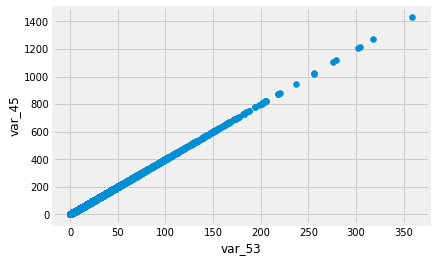

In [32]:
plt.scatter(x=[data.var_53], y= [data.var_45])
plt.ylabel('var_45')
plt.xlabel('var_53')
plt.show()
# Plot of fully correlated features

columns_to_drop_due_to_correlation = []
for index, values in sol.items():
    if values > 0.97:
        columns_to_drop_due_to_correlation.append(index[0])

len(list(set(columns_to_drop_due_to_correlation))) 
# there is lots of duplicates, so we use set to get unique features

data.drop(columns=columns_to_drop_due_to_correlation,axis=1, inplace=True)

Total number of features: 146
Number of categorical features: 20
Number of numerical features: 128


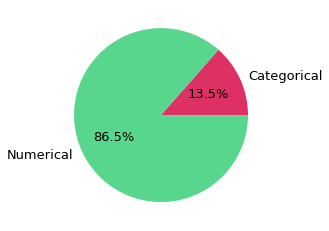

In [33]:
cat_features = list(data.select_dtypes(['category','object']).columns)
num_features = [col for col in data.columns if col not in cat_features]

print(f'Total number of features: {len(data.columns) - 2}')
print(f'\033[92mNumber of categorical features: {len(cat_features)}')
print(f'\033[96mNumber of numerical features: {len(num_features)}')

plt.pie([len(cat_features), len(num_features)], 
        labels=['Categorical', 'Numerical'],
        colors=['#DE3163', '#58D68D'],
        textprops={'fontsize': 13},
        autopct='%1.1f%%')
plt.show()

In [34]:
# gndr  --> onehotencoding because we gender do not have an order or rank
# 'dev_man' --> labelencoding
# 'device_os_name' --> labelencoding
# 'simcard_type' --> labelencoding
le = preprocessing.LabelEncoder()
data['dev_man'] = le.fit_transform(data['dev_man'])
data['device_os_name'] = le.fit_transform(data['device_os_name'])
data['simcard_type'] = le.fit_transform(data['simcard_type'])
data = pd.get_dummies(data, columns=['gndr'])

In [35]:
# There are features that represent numbers as strings, fixing it here
def fix_datatype(data: pd.DataFrame, columns: list) -> pd.DataFrame:
    for column in columns:
        data[column] = data[column].astype('int32')
    return data

features_to_fix_dtype = list(data.columns[data.dtypes.eq('category')]) + list(data.columns[data.dtypes.eq('object')])

data = fix_datatype(data, columns=features_to_fix_dtype)

Total number of features: 148
Number of categorical features: 0
Number of numerical features: 150


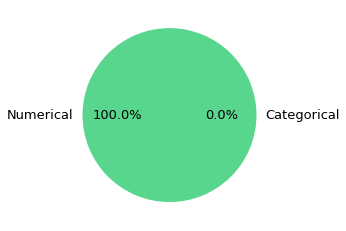

In [36]:
cat_features = list(data.select_dtypes(['category','object']).columns)
num_features = [col for col in data.columns if col not in cat_features]

print(f'Total number of features: {len(data.columns) - 2}')
print(f'\033[92mNumber of categorical features: {len(cat_features)}')
print(f'\033[96mNumber of numerical features: {len(num_features)}')

plt.pie([len(cat_features), len(num_features)], 
        labels=['Categorical', 'Numerical'],
        colors=['#DE3163', '#58D68D'],
        textprops={'fontsize': 13},
        autopct='%1.1f%%')
plt.show()

In [37]:
cat_features

[]

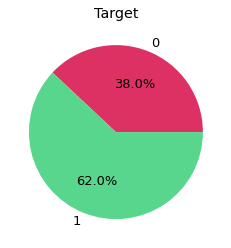

In [38]:
plt.pie([data.target.value_counts()[0],
         data.target.value_counts()[1]], 
        labels=['0', '1'],
        colors=['#DE3163', '#58D68D'],
        textprops={'fontsize': 13},
        autopct='%1.1f%%')
plt.title('Target')
plt.show()

In [39]:
# https://www.kaggle.com/ljjblackpig/3-steps-to-reduce-memory-size-for-the-dataset
def downcast_df_int_columns(df):
    list_of_columns = list(
        df.select_dtypes(include=["int32", "int64"]).columns)

    if len(list_of_columns) >= 1:
        max_string_length = max([
            len(col) for col in list_of_columns
        ])  # finds max string length for better status printing
        print("downcasting integers for:", list_of_columns, "\n")

        for col in list_of_columns:
            print("reduced memory usage for:  ",
                  col.ljust(max_string_length + 2)[:max_string_length + 2],
                  "from",
                  str(round(df[col].memory_usage(deep=True) * 1e-6,
                            2)).rjust(8),
                  "to",
                  end=" ")
            df[col] = pd.to_numeric(df[col], downcast="integer")
            print(
                str(round(df[col].memory_usage(deep=True) * 1e-6, 2)).rjust(8))
    else:
        print("no columns to downcast")
    gc.collect()
    print("done")

In [40]:
downcast_df_int_columns(data)

downcasting integers for: ['subscriber_id', 'trf', 'age', 'var_5', 'dev_man', 'device_os_name', 'var_8', 'is_dualsim', 'is_featurephone', 'is_smartphone', 'simcard_type', 'var_69', 'var_70', 'var_71', 'var_72', 'region', 'var_99', 'var_100', 'var_101', 'var_102', 'var_103', 'var_105', 'var_107', 'var_108', 'var_110', 'var_111', 'var_114', 'var_115', 'var_117', 'var_118', 'var_119', 'var_120', 'var_125', 'var_126', 'var_128', 'var_129', 'var_130', 'var_131', 'var_132', 'var_137', 'var_139', 'var_141', 'var_143', 'var_145', 'var_159', 'var_161', 'var_163', 'var_165', 'var_167', 'var_181', 'var_183', 'var_185', 'var_187', 'var_189', 'target', 'var_202', 'var_203', 'var_206', 'var_207', 'var_209', 'var_210', 'is_bundle_trf'] 

reduced memory usage for:   subscriber_id     from     2.96 to     2.96
reduced memory usage for:   trf               from     2.96 to     2.59
reduced memory usage for:   age               from     2.74 to     2.59
reduced memory usage for:   var_5             from 

# Install GPU

https://www.kaggle.com/lucamassaron/gpu-accelerated-lightgbm

In [41]:
!rm -r /opt/conda/lib/python3.7/site-packages/lightgbm

In [42]:
!git clone --recursive https://github.com/Microsoft/LightGBM

Cloning into 'LightGBM'...
remote: Enumerating objects: 25039, done.
remote: Counting objects: 100% (715/715), done.
remote: Compressing objects: 100% (387/387), done.
remote: Total 25039 (delta 462), reused 517 (delta 323), pack-reused 24324
Receiving objects: 100% (25039/25039), 18.62 MiB | 17.98 MiB/s, done.
Resolving deltas: 100% (18409/18409), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/kaggle/working/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.        
rem

In [43]:
!apt-get install -y -qq libboost-all-dev

Extracting templates from packages: 100%
Selecting previously unselected package libmagic-mgc.
(Reading database ... 103272 files and directories currently installed.)
Preparing to unpack .../000-libmagic-mgc_1%3a5.38-4_amd64.deb ...
Unpacking libmagic-mgc (1:5.38-4) ...
Selecting previously unselected package libmagic1:amd64.
Preparing to unpack .../001-libmagic1_1%3a5.38-4_amd64.deb ...
Unpacking libmagic1:amd64 (1:5.38-4) ...
Selecting previously unselected package file.
Preparing to unpack .../002-file_1%3a5.38-4_amd64.deb ...
Unpacking file (1:5.38-4) ...
Selecting previously unselected package libsigsegv2:amd64.
Preparing to unpack .../003-libsigsegv2_2.12-2_amd64.deb ...
Unpacking libsigsegv2:amd64 (2.12-2) ...
Selecting previously unselected package m4.
Preparing to unpack .../004-m4_1.4.18-4_amd64.deb ...
Unpacking m4 (1.4.18-4) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../005-autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Se

In [44]:
!rm /opt/conda/lib/libcurl.so.4

In [45]:
%%bash
cd LightGBM
mkdir build
cd build
cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
make -j$(nproc)

-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - not found
-- Looking for CL_VERSION_2_1
-- Looking for CL_VERSION_2_1 - not found
-- Looking for CL_VERSION_2_0
-- Looking for CL_VERSION_2_0 - not found
-- Looking for CL_VERSION_1_2
-- Looking for CL_VERSION_1_2 - found
-- Found OpenCL: /usr/local/cuda/lib64/libOpenCL.so (found vers

In [46]:
!cd LightGBM/python-package/;python3 setup.py install --precompile

running install
/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
running build
running build_py
creating build
creating build/lib
creating build/lib/lightgbm
copying lightgbm/basic.py -> build/lib/lightgbm
copying lightgbm/dask.py -> build/lib/lightgbm
copying lightgbm/libpath.py -> build/lib/lightgbm
copying lightgbm/__init__.py -> build/lib/lightgbm
copying lightgbm/plotting.py -> build/lib/lightgbm
copying lightgbm/compat.py -> build/lib/lightgbm
copying lightgbm/engine.py -> build/lib/lightgbm
copying lightgbm/sklearn.py -> build/lib/lightgbm
copying lightgbm/callback.py -> build/lib/lightgbm
running egg_info
creating lightgbm.egg-info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writing requirements to lightgbm.egg-info/requires.txt
writing top-lev

In [47]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!rm -r LightGBM

# # Model

In [48]:
!nvidia-smi

Tue Feb 22 16:29:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [49]:
X = data.drop(columns=['target','subscriber_id'], axis=1)
y = data['target']

# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
# some lgbm parametrs from my previous projects
lgb_params = {
    'lambda_l1': 0.12316592750974795,
    'lambda_l2': 0.8462662628054513,
    'num_leaves': 171,
    'feature_fraction': 0.5759943289441473,
    'bagging_fraction': 0.703925954466332,
    'bagging_freq': 5,
    'min_child_samples': 25,
    'learning_rate': 0.00965962567977748,
    'task': 'train',
    'objective': 'binary',
    'verbose': -1,
    'boosting_type': 'gbdt',
    'seed': 42,
    'metric': 'AUC',
    'is_unbalance': True,
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'num_threads': 4
}

In [51]:
scaler = preprocessing.MinMaxScaler()
X_N = scaler.fit_transform(X)
x_train_N, x_test_N, y_train_N, y_test_N = train_test_split(X, y, test_size=0.3, random_state=42)

## LightGBM

In [52]:
# DATA WITH NORMALIZATION
preds_N = np.zeros(x_test_N.shape[0])
kf = StratifiedKFold(n_splits=10, shuffle=True)
n = 0
for trn_idx, test_idx in kf.split(x_train_N, y_train_N):
    X_tr, X_val = x_train_N.iloc[trn_idx], x_train_N.iloc[test_idx]
    y_tr, y_val = y_train_N.iloc[trn_idx], y_train_N.iloc[test_idx]
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_valid = lgb.Dataset(X_val, y_val, reference=lgb_train)
    # Training
    lgb_model_N = lgb.train(lgb_params,
                       lgb_train,
                       valid_sets=[lgb_train, lgb_valid],
                       num_boost_round=1000,
                       early_stopping_rounds=200,
                       verbose_eval=500)
    preds_N += lgb_model_N.predict(x_test_N) / kf.n_splits

Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.946681	valid_1's auc: 0.754685
[1000]	training's auc: 0.990763	valid_1's auc: 0.755888
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.990763	valid_1's auc: 0.755888
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.946171	valid_1's auc: 0.777096
Early stopping, best iteration is:
[698]	training's auc: 0.971214	valid_1's auc: 0.779538
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.945972	valid_1's auc: 0.778996
[1000]	training's auc: 0.990633	valid_1's auc: 0.784214
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.990633	valid_1's auc: 0.784214
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.946658	valid_1's auc: 0.763857
[1000]	training's auc: 0.990845	valid_1's auc: 0.766694
Did not meet early stopping. Best iteration is:
[1000]	training's 

In [53]:
preds = np.zeros(x_test.shape[0])
kf = StratifiedKFold(n_splits=10, shuffle=True)
n = 0
for trn_idx, test_idx in kf.split(x_train, y_train):
    X_tr, X_val = x_train.iloc[trn_idx], x_train.iloc[test_idx]
    y_tr, y_val = y_train.iloc[trn_idx], y_train.iloc[test_idx]
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_valid = lgb.Dataset(X_val, y_val, reference=lgb_train)
    # Training
    lgb_model = lgb.train(lgb_params,
                       lgb_train,
                       valid_sets=[lgb_train, lgb_valid],
                       num_boost_round=1000,
                       early_stopping_rounds=200,
                       verbose_eval=500)
    preds += lgb_model.predict(x_test) / kf.n_splits

Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.946832	valid_1's auc: 0.752995
Early stopping, best iteration is:
[767]	training's auc: 0.977904	valid_1's auc: 0.753863
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.947076	valid_1's auc: 0.770554
[1000]	training's auc: 0.990872	valid_1's auc: 0.773312
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.990872	valid_1's auc: 0.773312
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.946391	valid_1's auc: 0.765852
Early stopping, best iteration is:
[724]	training's auc: 0.97402	valid_1's auc: 0.767855
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.946507	valid_1's auc: 0.754623
[1000]	training's auc: 0.990691	valid_1's auc: 0.758597
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.990691	valid_1's auc: 0.758597
Training until validation scores 

In [54]:
# DATA WITH NORMALIZATION
preds_N = np.zeros(x_test_N.shape[0])
kf = StratifiedKFold(n_splits=10, shuffle=True)
n = 0
for trn_idx, test_idx in kf.split(x_train_N, y_train_N):
    X_tr, X_val = x_train_N.iloc[trn_idx], x_train_N.iloc[test_idx]
    y_tr, y_val = y_train_N.iloc[trn_idx], y_train_N.iloc[test_idx]
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_valid = lgb.Dataset(X_val, y_val, reference=lgb_train)
    # Training
    lgb_model_N = lgb.train(lgb_params,
                       lgb_train,
                       valid_sets=[lgb_train, lgb_valid],
                       num_boost_round=1000,
                       early_stopping_rounds=200,
                       verbose_eval=500)
    preds_N += lgb_model_N.predict(x_test_N) / kf.n_splits

Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.946662	valid_1's auc: 0.765308
[1000]	training's auc: 0.990687	valid_1's auc: 0.768858
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.990687	valid_1's auc: 0.768858
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.946986	valid_1's auc: 0.750105
[1000]	training's auc: 0.990471	valid_1's auc: 0.753444
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.990471	valid_1's auc: 0.753444
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.946903	valid_1's auc: 0.772828
Early stopping, best iteration is:
[619]	training's auc: 0.96313	valid_1's auc: 0.774601
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.946492	valid_1's auc: 0.763584
[1000]	training's auc: 0.99039	valid_1's auc: 0.766175
Did not meet early stopping. Best iteration is:
[1000]	training's au

In [55]:
print(f'score without normalization:{roc_auc_score(y_test, preds)}')
print(f'score with normalization:{roc_auc_score(y_test, preds_N)}')

score without normalization:0.7735414295750808
score with normalization:0.773284426548814


In [56]:
print(f1_score(y_test_N,np.round(lgb_model_N.predict(x_test_N))))
print(f1_score(y_test,np.round(lgb_model.predict(x_test))))

0.7706947713087077
0.7706638006039204


# Fine tuning using Optuna and model related visualization
Decided to use LightGBM as a final model because it's faster than xgboost and performs better in that particular task

In [57]:
def LightGBM(params, X_train_adv, X_valid_adv, y_train_adv, y_valid_adv):
    # Set data
    lgb_train = lgb.Dataset(X_train_adv, y_train_adv)
    lgb_valid = lgb.Dataset(X_valid_adv, y_valid_adv, reference = lgb_train)
    # Training
    model = lgb.train(
        params,
        lgb_train,
        valid_sets = [lgb_train, lgb_valid],
        num_boost_round = 2000,
        early_stopping_rounds = 250,
        verbose_eval=500
    )
    # Prediction
    y_pred = model.predict(X_valid_adv, num_iteration = model.best_iteration)
    # Evaluation
    ROC_AUC_Score = roc_auc_score(y_valid_adv,y_pred)
    print('ROC AUC Score of LightGBM =', ROC_AUC_Score)
    return ROC_AUC_Score

In [58]:
def objective(trial):
    params = {
        'task': 'train',
        'objective': 'binary',
        'verbose': -1,
        'boosting_type': 'gbdt',
        'seed': 42,
        'metric': 'AUC',
        'is_unbalance': True,
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'num_threads': 4,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.1, 0.9),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.1, 0.9),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4,
                                                  0.8),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4,
                                                  0.8),
        'min_child_samples': trial.suggest_int('min_child_samples', 25, 50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    }

    return LightGBM(params, x_train_N, x_test_N, y_train_N, y_test_N)

In [59]:
from optuna.samplers import TPESampler

study = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed=42))
study.optimize(objective, n_trials = 40)


[I 2022-02-22 17:41:09,178] A new study created in memory with name: no-name-eabadaf9-1b2d-4250-b03e-c772babea664


Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.872218	valid_1's auc: 0.743469
Early stopping, best iteration is:
[672]	training's auc: 0.872707	valid_1's auc: 0.743871


[I 2022-02-22 17:45:14,833] Trial 0 finished with value: 0.7438713930183225 and parameters: {'lambda_l1': 0.22772048646396836, 'lambda_l2': 0.8076291868832455, 'num_leaves': 376, 'feature_fraction': 0.6394633936788147, 'bagging_fraction': 0.46240745617697465, 'min_child_samples': 29, 'learning_rate': 1.7073967431528103e-05}. Best is trial 0 with value: 0.7438713930183225.


ROC AUC Score of LightGBM = 0.7438713930183225
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.866458	valid_1's auc: 0.745067
Early stopping, best iteration is:
[304]	training's auc: 0.866058	valid_1's auc: 0.745244


[I 2022-02-22 17:47:12,220] Trial 1 finished with value: 0.745243555786906 and parameters: {'lambda_l1': 0.670721300885889, 'lambda_l2': 0.374635990894187, 'num_leaves': 363, 'feature_fraction': 0.408233797718321, 'bagging_fraction': 0.7879639408647978, 'min_child_samples': 46, 'learning_rate': 7.068974950624602e-05}. Best is trial 1 with value: 0.745243555786906.


ROC AUC Score of LightGBM = 0.745243555786906
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.855904	valid_1's auc: 0.756297
[1000]	training's auc: 0.893231	valid_1's auc: 0.764052
[1500]	training's auc: 0.92424	valid_1's auc: 0.768093
[2000]	training's auc: 0.948091	valid_1's auc: 0.770473
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.948091	valid_1's auc: 0.770473


[I 2022-02-22 17:51:35,972] Trial 2 finished with value: 0.7704733496299245 and parameters: {'lambda_l1': 0.14910943101314156, 'lambda_l2': 0.14962783074537747, 'num_leaves': 157, 'feature_fraction': 0.6099025726528952, 'bagging_fraction': 0.5727780074568464, 'min_child_samples': 32, 'learning_rate': 0.0028016351587162596}. Best is trial 2 with value: 0.7704733496299245.


ROC AUC Score of LightGBM = 0.7704733496299245
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.842966	valid_1's auc: 0.748672
[1000]	training's auc: 0.863401	valid_1's auc: 0.755431
[1500]	training's auc: 0.881225	valid_1's auc: 0.75978
[2000]	training's auc: 0.897228	valid_1's auc: 0.762816
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.897228	valid_1's auc: 0.762816


[I 2022-02-22 17:56:45,273] Trial 3 finished with value: 0.7628163333350344 and parameters: {'lambda_l1': 0.13586605694188655, 'lambda_l2': 0.1900101682601018, 'num_leaves': 189, 'feature_fraction': 0.5824279936868144, 'bagging_fraction': 0.7140703845572055, 'min_child_samples': 30, 'learning_rate': 0.0011400863701127321}. Best is trial 2 with value: 0.7704733496299245.


ROC AUC Score of LightGBM = 0.7628163333350344
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 1	valid_1's auc: 0.760728
Early stopping, best iteration is:
[361]	training's auc: 1	valid_1's auc: 0.761269


[I 2022-02-22 17:58:41,437] Trial 4 finished with value: 0.7612692969160658 and parameters: {'lambda_l1': 0.3675421612872964, 'lambda_l2': 0.11074521188469559, 'num_leaves': 312, 'feature_fraction': 0.4682096494749166, 'bagging_fraction': 0.4260206371941118, 'min_child_samples': 49, 'learning_rate': 0.07286653737491042}. Best is trial 2 with value: 0.7704733496299245.


ROC AUC Score of LightGBM = 0.7612692969160658
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.759525	valid_1's auc: 0.731054
[1000]	training's auc: 0.772546	valid_1's auc: 0.739134
[1500]	training's auc: 0.784076	valid_1's auc: 0.746116
[2000]	training's auc: 0.79364	valid_1's auc: 0.751088
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.79364	valid_1's auc: 0.751088


[I 2022-02-22 18:00:37,766] Trial 5 finished with value: 0.751087959064596 and parameters: {'lambda_l1': 0.590754602820555, 'lambda_l2': 0.1952879324593401, 'num_leaves': 51, 'feature_fraction': 0.6736932106048628, 'bagging_fraction': 0.5760609974958406, 'min_child_samples': 28, 'learning_rate': 0.0009565499215943821}. Best is trial 2 with value: 0.7704733496299245.


ROC AUC Score of LightGBM = 0.751087959064596
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.821178	valid_1's auc: 0.746675
[1000]	training's auc: 0.845086	valid_1's auc: 0.755059
[1500]	training's auc: 0.865319	valid_1's auc: 0.760219
[2000]	training's auc: 0.883688	valid_1's auc: 0.763988
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.883688	valid_1's auc: 0.763988


[I 2022-02-22 18:04:33,458] Trial 6 finished with value: 0.7639878847262837 and parameters: {'lambda_l1': 0.10784871841803294, 'lambda_l2': 0.7374153648541821, 'num_leaves': 134, 'feature_fraction': 0.6650089137415929, 'bagging_fraction': 0.5246844304357644, 'min_child_samples': 38, 'learning_rate': 0.0015375920235481753}. Best is trial 2 with value: 0.7704733496299245.


ROC AUC Score of LightGBM = 0.7639878847262837
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[156]	training's auc: 0.999628	valid_1's auc: 0.76513


[I 2022-02-22 18:06:25,371] Trial 7 finished with value: 0.7651301941131541 and parameters: {'lambda_l1': 0.15010528365193862, 'lambda_l2': 0.841819280457216, 'num_leaves': 398, 'feature_fraction': 0.7757995766256757, 'bagging_fraction': 0.7579309401710596, 'min_child_samples': 40, 'learning_rate': 0.04869640941520897}. Best is trial 2 with value: 0.7704733496299245.


ROC AUC Score of LightGBM = 0.7651301941131541
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.832062	valid_1's auc: 0.765726
[1000]	training's auc: 0.878701	valid_1's auc: 0.767795
[1500]	training's auc: 0.911957	valid_1's auc: 0.768538
Early stopping, best iteration is:
[1626]	training's auc: 0.918706	valid_1's auc: 0.768631


[I 2022-02-22 18:07:21,756] Trial 8 finished with value: 0.7686311543872362 and parameters: {'lambda_l1': 0.12146280526491705, 'lambda_l2': 0.15382083992151838, 'num_leaves': 25, 'feature_fraction': 0.5301321323053058, 'bagging_fraction': 0.5554709158757929, 'min_child_samples': 32, 'learning_rate': 0.02065142557895925}. Best is trial 2 with value: 0.7704733496299245.


ROC AUC Score of LightGBM = 0.7686311543872362
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 1	valid_1's auc: 0.760344
[1000]	training's auc: 1	valid_1's auc: 0.761567
Early stopping, best iteration is:
[1175]	training's auc: 1	valid_1's auc: 0.761647


[I 2022-02-22 18:10:56,760] Trial 9 finished with value: 0.7616471805026086 and parameters: {'lambda_l1': 0.21899247389411858, 'lambda_l2': 0.18538716004172406, 'num_leaves': 279, 'feature_fraction': 0.45636968998990507, 'bagging_fraction': 0.7208787923016159, 'min_child_samples': 26, 'learning_rate': 0.08862326508576249}. Best is trial 2 with value: 0.7704733496299245.


ROC AUC Score of LightGBM = 0.7616471805026086
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.992633	valid_1's auc: 0.765559
[1000]	training's auc: 0.999954	valid_1's auc: 0.769034
Early stopping, best iteration is:
[1099]	training's auc: 0.999988	valid_1's auc: 0.76918


[I 2022-02-22 18:18:33,549] Trial 10 finished with value: 0.7691800501145694 and parameters: {'lambda_l1': 0.3091429955434087, 'lambda_l2': 0.34141239452853367, 'num_leaves': 497, 'feature_fraction': 0.7526717232169267, 'bagging_fraction': 0.6560354009870225, 'min_child_samples': 34, 'learning_rate': 0.007219264738754508}. Best is trial 2 with value: 0.7704733496299245.


ROC AUC Score of LightGBM = 0.7691800501145694
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.99306	valid_1's auc: 0.765869
[1000]	training's auc: 0.999963	valid_1's auc: 0.769359
Early stopping, best iteration is:
[1093]	training's auc: 0.999992	valid_1's auc: 0.769437


[I 2022-02-22 18:26:16,965] Trial 11 finished with value: 0.7694372402624465 and parameters: {'lambda_l1': 0.3940279517076065, 'lambda_l2': 0.35030071708213506, 'num_leaves': 510, 'feature_fraction': 0.7970125535876504, 'bagging_fraction': 0.6469817891972085, 'min_child_samples': 35, 'learning_rate': 0.007190168301086835}. Best is trial 2 with value: 0.7704733496299245.


ROC AUC Score of LightGBM = 0.7694372402624465
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.97759	valid_1's auc: 0.763149
[1000]	training's auc: 0.998302	valid_1's auc: 0.768136
[1500]	training's auc: 0.999945	valid_1's auc: 0.769576
[2000]	training's auc: 1	valid_1's auc: 0.769693
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 1	valid_1's auc: 0.769693


[I 2022-02-22 18:37:18,677] Trial 12 finished with value: 0.76969289941533 and parameters: {'lambda_l1': 0.47857994926457037, 'lambda_l2': 0.47850162565415294, 'num_leaves': 508, 'feature_fraction': 0.7206988713158603, 'bagging_fraction': 0.632734848163876, 'min_child_samples': 35, 'learning_rate': 0.004901256212679845}. Best is trial 2 with value: 0.7704733496299245.


ROC AUC Score of LightGBM = 0.76969289941533
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.813242	valid_1's auc: 0.736068
[1000]	training's auc: 0.820031	valid_1's auc: 0.739067
[1500]	training's auc: 0.827106	valid_1's auc: 0.742045
[2000]	training's auc: 0.833432	valid_1's auc: 0.744738
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.833432	valid_1's auc: 0.744738


[I 2022-02-22 18:42:19,454] Trial 13 finished with value: 0.744738480538502 and parameters: {'lambda_l1': 0.8454294467431172, 'lambda_l2': 0.5004884902425522, 'num_leaves': 182, 'feature_fraction': 0.7087696049520285, 'bagging_fraction': 0.6103255200926708, 'min_child_samples': 39, 'learning_rate': 0.00027307423899287984}. Best is trial 2 with value: 0.7704733496299245.


ROC AUC Score of LightGBM = 0.744738480538502
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.875149	valid_1's auc: 0.762149
[1000]	training's auc: 0.926684	valid_1's auc: 0.769366
[1500]	training's auc: 0.959275	valid_1's auc: 0.771654
[2000]	training's auc: 0.977719	valid_1's auc: 0.772278
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.977719	valid_1's auc: 0.772278


[I 2022-02-22 18:46:05,668] Trial 14 finished with value: 0.772278018484213 and parameters: {'lambda_l1': 0.1894094576898152, 'lambda_l2': 0.5198609386555615, 'num_leaves': 145, 'feature_fraction': 0.5667698433310002, 'bagging_fraction': 0.5047025536006757, 'min_child_samples': 42, 'learning_rate': 0.004978252292666552}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.772278018484213
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.784448	valid_1's auc: 0.735509
[1000]	training's auc: 0.788374	valid_1's auc: 0.737153
[1500]	training's auc: 0.792209	valid_1's auc: 0.738851
[2000]	training's auc: 0.796902	valid_1's auc: 0.741416
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.796902	valid_1's auc: 0.741416


[I 2022-02-22 18:49:20,172] Trial 15 finished with value: 0.7414164255349551 and parameters: {'lambda_l1': 0.19128208193620022, 'lambda_l2': 0.10292930677894871, 'num_leaves': 107, 'feature_fraction': 0.5848459033604513, 'bagging_fraction': 0.49985942161478525, 'min_child_samples': 43, 'learning_rate': 0.0002172869118156671}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7414164255349551
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.890126	valid_1's auc: 0.759214
[1000]	training's auc: 0.931199	valid_1's auc: 0.766086
[1500]	training's auc: 0.960961	valid_1's auc: 0.769262
[2000]	training's auc: 0.980005	valid_1's auc: 0.771001
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.980005	valid_1's auc: 0.771001


[I 2022-02-22 18:54:57,524] Trial 16 finished with value: 0.7710012537147892 and parameters: {'lambda_l1': 0.167838756256177, 'lambda_l2': 0.24081225599631456, 'num_leaves': 233, 'feature_fraction': 0.5530697640785134, 'bagging_fraction': 0.47728765021807684, 'min_child_samples': 43, 'learning_rate': 0.0030222427971429927}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7710012537147892
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.997031	valid_1's auc: 0.769406
Early stopping, best iteration is:
[406]	training's auc: 0.992163	valid_1's auc: 0.76967


[I 2022-02-22 18:56:40,690] Trial 17 finished with value: 0.7696702066673131 and parameters: {'lambda_l1': 0.18932646635860037, 'lambda_l2': 0.2624022025267638, 'num_leaves': 231, 'feature_fraction': 0.5268639693170385, 'bagging_fraction': 0.42357950995947646, 'min_child_samples': 43, 'learning_rate': 0.02047147040324723}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7696702066673131
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.77435	valid_1's auc: 0.734355
[1000]	training's auc: 0.778546	valid_1's auc: 0.736167
[1500]	training's auc: 0.783529	valid_1's auc: 0.739133
[2000]	training's auc: 0.788182	valid_1's auc: 0.741771
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.788182	valid_1's auc: 0.741771


[I 2022-02-22 18:59:22,455] Trial 18 finished with value: 0.7417710209865391 and parameters: {'lambda_l1': 0.27456038642433456, 'lambda_l2': 0.578730915955465, 'num_leaves': 86, 'feature_fraction': 0.5412961465505883, 'bagging_fraction': 0.481016180826694, 'min_child_samples': 50, 'learning_rate': 0.00027136956542429954}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7417710209865391
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.994171	valid_1's auc: 0.769667
Early stopping, best iteration is:
[575]	training's auc: 0.997036	valid_1's auc: 0.769805


[I 2022-02-22 19:01:29,116] Trial 19 finished with value: 0.7698054445584186 and parameters: {'lambda_l1': 0.17649727733996287, 'lambda_l2': 0.26121585155793925, 'num_leaves': 229, 'feature_fraction': 0.4807171468064966, 'bagging_fraction': 0.4046900766336022, 'min_child_samples': 43, 'learning_rate': 0.01802913216152524}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7698054445584186
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.863811	valid_1's auc: 0.747391
[1000]	training's auc: 0.87574	valid_1's auc: 0.75089
[1500]	training's auc: 0.886737	valid_1's auc: 0.754249
[2000]	training's auc: 0.896688	valid_1's auc: 0.756925
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.896688	valid_1's auc: 0.756925


[I 2022-02-22 19:08:23,169] Trial 20 finished with value: 0.7569245032346523 and parameters: {'lambda_l1': 0.26182518075568917, 'lambda_l2': 0.6300329320466598, 'num_leaves': 306, 'feature_fraction': 0.567860303692635, 'bagging_fraction': 0.5208542227455358, 'min_child_samples': 46, 'learning_rate': 0.0005282461262432627}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7569245032346523
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.84537	valid_1's auc: 0.755502
[1000]	training's auc: 0.883245	valid_1's auc: 0.763949
[1500]	training's auc: 0.914564	valid_1's auc: 0.768356
[2000]	training's auc: 0.93864	valid_1's auc: 0.770604
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.93864	valid_1's auc: 0.770604


[I 2022-02-22 19:12:09,324] Trial 21 finished with value: 0.7706042497018813 and parameters: {'lambda_l1': 0.1583563541546439, 'lambda_l2': 0.1418919619010081, 'num_leaves': 137, 'feature_fraction': 0.6415701386070043, 'bagging_fraction': 0.5503540020940857, 'min_child_samples': 46, 'learning_rate': 0.0029796760970749398}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7706042497018813
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.805367	valid_1's auc: 0.751152
[1000]	training's auc: 0.835727	valid_1's auc: 0.761071
[1500]	training's auc: 0.861221	valid_1's auc: 0.766079
[2000]	training's auc: 0.88252	valid_1's auc: 0.768803
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.88252	valid_1's auc: 0.768803


[I 2022-02-22 19:14:31,564] Trial 22 finished with value: 0.7688032042024111 and parameters: {'lambda_l1': 0.16153949918135202, 'lambda_l2': 0.24265998596459865, 'num_leaves': 74, 'feature_fraction': 0.6350956114501157, 'bagging_fraction': 0.46716010924539414, 'min_child_samples': 46, 'learning_rate': 0.0030183536003996645}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7688032042024111
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.740575	valid_1's auc: 0.736369
[1000]	training's auc: 0.757366	valid_1's auc: 0.747987
[1500]	training's auc: 0.767232	valid_1's auc: 0.752695
[2000]	training's auc: 0.775127	valid_1's auc: 0.755629
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.775127	valid_1's auc: 0.755629


[I 2022-02-22 19:15:04,404] Trial 23 finished with value: 0.7556287030941409 and parameters: {'lambda_l1': 0.10114838674657126, 'lambda_l2': 0.13820477536326037, 'num_leaves': 5, 'feature_fraction': 0.5071858512446394, 'bagging_fraction': 0.5391499794508257, 'min_child_samples': 42, 'learning_rate': 0.01055439580609141}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7556287030941409
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.863996	valid_1's auc: 0.754521
[1000]	training's auc: 0.896363	valid_1's auc: 0.761931
[1500]	training's auc: 0.923289	valid_1's auc: 0.765968
[2000]	training's auc: 0.945569	valid_1's auc: 0.76869
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.945569	valid_1's auc: 0.76869


[I 2022-02-22 19:20:17,179] Trial 24 finished with value: 0.7686899275839367 and parameters: {'lambda_l1': 0.2178574375178755, 'lambda_l2': 0.3990558501575177, 'num_leaves': 207, 'feature_fraction': 0.6117507238582107, 'bagging_fraction': 0.44776799744533813, 'min_child_samples': 48, 'learning_rate': 0.0021174939514268538}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7686899275839367
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.807122	valid_1's auc: 0.742453
[1000]	training's auc: 0.820807	valid_1's auc: 0.748468
[1500]	training's auc: 0.832345	valid_1's auc: 0.752989
[2000]	training's auc: 0.842705	valid_1's auc: 0.756296
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.842705	valid_1's auc: 0.756296


[I 2022-02-22 19:24:00,639] Trial 25 finished with value: 0.7562959787565938 and parameters: {'lambda_l1': 0.1182607017279698, 'lambda_l2': 0.12613505456150814, 'num_leaves': 132, 'feature_fraction': 0.5634036827674378, 'bagging_fraction': 0.5027574011754048, 'min_child_samples': 41, 'learning_rate': 0.0007256932574038737}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7562959787565938
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.917356	valid_1's auc: 0.762216
[1000]	training's auc: 0.965573	valid_1's auc: 0.768774
[1500]	training's auc: 0.988747	valid_1's auc: 0.771027
[2000]	training's auc: 0.996721	valid_1's auc: 0.771475
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.996721	valid_1's auc: 0.771475


[I 2022-02-22 19:30:10,493] Trial 26 finished with value: 0.7714750796542672 and parameters: {'lambda_l1': 0.13459432701032226, 'lambda_l2': 0.21957465633827847, 'num_leaves': 257, 'feature_fraction': 0.6759710886560624, 'bagging_fraction': 0.5903511750638757, 'min_child_samples': 45, 'learning_rate': 0.0042678059538121225}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7714750796542672
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.99451	valid_1's auc: 0.769402
Early stopping, best iteration is:
[719]	training's auc: 0.999448	valid_1's auc: 0.769992


[I 2022-02-22 19:33:42,919] Trial 27 finished with value: 0.7699917326270344 and parameters: {'lambda_l1': 0.13201361817821702, 'lambda_l2': 0.22466776554303994, 'num_leaves': 327, 'feature_fraction': 0.6867420091067878, 'bagging_fraction': 0.6887339947013522, 'min_child_samples': 44, 'learning_rate': 0.01195905361449761}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7699917326270344
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[242]	training's auc: 0.995719	valid_1's auc: 0.766043


[I 2022-02-22 19:35:06,345] Trial 28 finished with value: 0.7660430243615326 and parameters: {'lambda_l1': 0.18727854942702526, 'lambda_l2': 0.3149020484272565, 'num_leaves': 260, 'feature_fraction': 0.5008762192128358, 'bagging_fraction': 0.6042273578297215, 'min_child_samples': 38, 'learning_rate': 0.03478297163999658}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7660430243615326
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.971656	valid_1's auc: 0.764794
[1000]	training's auc: 0.997306	valid_1's auc: 0.769372
[1500]	training's auc: 0.99988	valid_1's auc: 0.770439
Early stopping, best iteration is:
[1523]	training's auc: 0.999898	valid_1's auc: 0.77052


[I 2022-02-22 19:43:12,584] Trial 29 finished with value: 0.7705197898113983 and parameters: {'lambda_l1': 0.23555027717027083, 'lambda_l2': 0.428363959576142, 'num_leaves': 449, 'feature_fraction': 0.622795887309389, 'bagging_fraction': 0.44936837004790936, 'min_child_samples': 48, 'learning_rate': 0.005295583415395149}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7705197898113983
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.832971	valid_1's auc: 0.742463
Early stopping, best iteration is:
[293]	training's auc: 0.833134	valid_1's auc: 0.742661


[I 2022-02-22 19:44:37,841] Trial 30 finished with value: 0.7426612605532336 and parameters: {'lambda_l1': 0.3359186004959711, 'lambda_l2': 0.294741969790148, 'num_leaves': 232, 'feature_fraction': 0.4162764280199502, 'bagging_fraction': 0.48973427886836424, 'min_child_samples': 41, 'learning_rate': 1.2246651174215794e-05}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7426612605532336
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.862672	valid_1's auc: 0.757064
[1000]	training's auc: 0.905041	valid_1's auc: 0.765227
[1500]	training's auc: 0.937847	valid_1's auc: 0.769035
[2000]	training's auc: 0.960668	valid_1's auc: 0.770707
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.960668	valid_1's auc: 0.770707


[I 2022-02-22 19:48:56,596] Trial 31 finished with value: 0.7707074557755085 and parameters: {'lambda_l1': 0.1627728847264256, 'lambda_l2': 0.1646639465710939, 'num_leaves': 163, 'feature_fraction': 0.6625838845707032, 'bagging_fraction': 0.5731716250009739, 'min_child_samples': 45, 'learning_rate': 0.0032372213237689905}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7707074557755085
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.80941	valid_1's auc: 0.737531
[1000]	training's auc: 0.810696	valid_1's auc: 0.737832
Early stopping, best iteration is:
[759]	training's auc: 0.810248	valid_1's auc: 0.737881


[I 2022-02-22 19:51:18,503] Trial 32 finished with value: 0.737881017873516 and parameters: {'lambda_l1': 0.13451616098456415, 'lambda_l2': 0.2206082977128022, 'num_leaves': 173, 'feature_fraction': 0.6501743421220905, 'bagging_fraction': 0.5801835944852072, 'min_child_samples': 45, 'learning_rate': 6.0308772226386006e-05}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.737881017873516
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.911208	valid_1's auc: 0.7592
[1000]	training's auc: 0.956006	valid_1's auc: 0.766607
[1500]	training's auc: 0.982096	valid_1's auc: 0.769681
[2000]	training's auc: 0.993787	valid_1's auc: 0.77051
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.993787	valid_1's auc: 0.77051


[I 2022-02-22 19:57:59,521] Trial 33 finished with value: 0.770510059487661 and parameters: {'lambda_l1': 0.16637266709707377, 'lambda_l2': 0.16995544751082228, 'num_leaves': 277, 'feature_fraction': 0.7152474345736958, 'bagging_fraction': 0.61958723820044, 'min_child_samples': 47, 'learning_rate': 0.0034115625101485106}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.770510059487661
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.849755	valid_1's auc: 0.750233
[1000]	training's auc: 0.872587	valid_1's auc: 0.757037
[1500]	training's auc: 0.892521	valid_1's auc: 0.761407
[2000]	training's auc: 0.910132	valid_1's auc: 0.764409
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.910132	valid_1's auc: 0.764409


[I 2022-02-22 20:03:10,458] Trial 34 finished with value: 0.7644090444379802 and parameters: {'lambda_l1': 0.21145437400338735, 'lambda_l2': 0.20424594720760592, 'num_leaves': 204, 'feature_fraction': 0.5963367648596625, 'bagging_fraction': 0.5211181883297478, 'min_child_samples': 44, 'learning_rate': 0.0013202776100129153}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7644090444379802
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.909049	valid_1's auc: 0.757136
[1000]	training's auc: 0.941537	valid_1's auc: 0.763348
[1500]	training's auc: 0.965237	valid_1's auc: 0.766664
[2000]	training's auc: 0.98137	valid_1's auc: 0.768736
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.98137	valid_1's auc: 0.768736


[I 2022-02-22 20:10:48,954] Trial 35 finished with value: 0.7687355512347473 and parameters: {'lambda_l1': 0.14190339233570276, 'lambda_l2': 0.16923302131680606, 'num_leaves': 343, 'feature_fraction': 0.5589116945668428, 'bagging_fraction': 0.5821551597942064, 'min_child_samples': 40, 'learning_rate': 0.002042784939342822}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7687355512347473
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.879612	valid_1's auc: 0.76136
[1000]	training's auc: 0.932308	valid_1's auc: 0.769108
[1500]	training's auc: 0.964107	valid_1's auc: 0.770795
[2000]	training's auc: 0.981311	valid_1's auc: 0.7713
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.981311	valid_1's auc: 0.7713


[I 2022-02-22 20:14:50,016] Trial 36 finished with value: 0.7713002230149374 and parameters: {'lambda_l1': 0.1161023316180241, 'lambda_l2': 0.26342250937213896, 'num_leaves': 154, 'feature_fraction': 0.6907411215881624, 'bagging_fraction': 0.47094701896002095, 'min_child_samples': 45, 'learning_rate': 0.0048202557378362355}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7713002230149374
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.993807	valid_1's auc: 0.768637
Early stopping, best iteration is:
[739]	training's auc: 0.999509	valid_1's auc: 0.769816


[I 2022-02-22 20:19:00,104] Trial 37 finished with value: 0.7698155831474875 and parameters: {'lambda_l1': 0.12215980598383118, 'lambda_l2': 0.28877099042498033, 'num_leaves': 384, 'feature_fraction': 0.7327380141353167, 'bagging_fraction': 0.4689718860925684, 'min_child_samples': 50, 'learning_rate': 0.010091973164046551}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7698155831474875
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.810878	valid_1's auc: 0.740315
[1000]	training's auc: 0.826152	valid_1's auc: 0.746897
[1500]	training's auc: 0.839345	valid_1's auc: 0.752055
[2000]	training's auc: 0.850723	valid_1's auc: 0.755562
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.850723	valid_1's auc: 0.755562


[I 2022-02-22 20:23:08,048] Trial 38 finished with value: 0.755562172856139 and parameters: {'lambda_l1': 0.11392345326029933, 'lambda_l2': 0.25538352641951845, 'num_leaves': 144, 'feature_fraction': 0.688131844585796, 'bagging_fraction': 0.4409269825843778, 'min_child_samples': 42, 'learning_rate': 0.0007594978159407194}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.755562172856139
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.94024	valid_1's auc: 0.763128
[1000]	training's auc: 0.984932	valid_1's auc: 0.769168
[1500]	training's auc: 0.997476	valid_1's auc: 0.770623
Early stopping, best iteration is:
[1577]	training's auc: 0.998135	valid_1's auc: 0.77074


[I 2022-02-22 20:29:25,197] Trial 39 finished with value: 0.7707398788472628 and parameters: {'lambda_l1': 0.10433415128334553, 'lambda_l2': 0.3248768005043586, 'num_leaves': 295, 'feature_fraction': 0.7532732587572686, 'bagging_fraction': 0.41666508496476784, 'min_child_samples': 48, 'learning_rate': 0.005088687014378344}. Best is trial 14 with value: 0.772278018484213.


ROC AUC Score of LightGBM = 0.7707398788472628


In [60]:
print(study.best_params)

{'lambda_l1': 0.1894094576898152, 'lambda_l2': 0.5198609386555615, 'num_leaves': 145, 'feature_fraction': 0.5667698433310002, 'bagging_fraction': 0.5047025536006757, 'min_child_samples': 42, 'learning_rate': 0.004978252292666552}


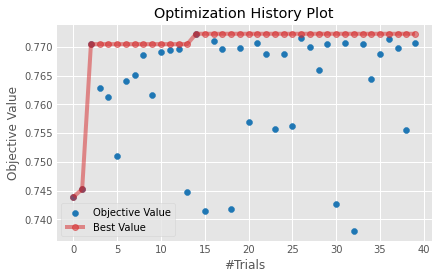

In [61]:
optuna.visualization.matplotlib.plot_optimization_history(study);

<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

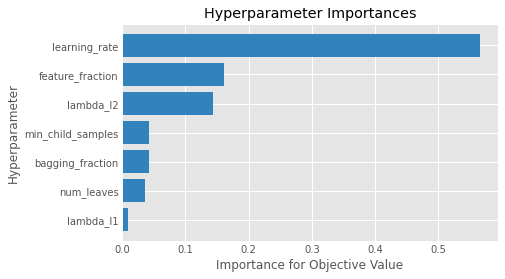

In [62]:
optuna.visualization.matplotlib.plot_param_importances(study)

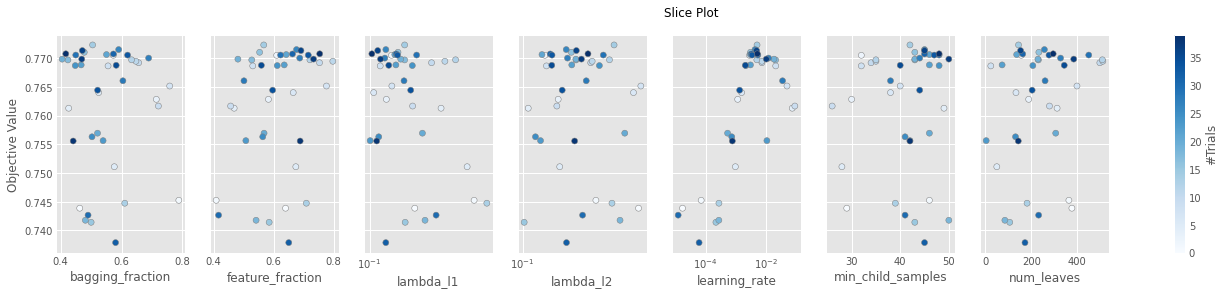

In [63]:
optuna.visualization.matplotlib.plot_slice(study);

In [64]:
tuned_params = {**study.best_params}
tuned_params

{'lambda_l1': 0.1894094576898152,
 'lambda_l2': 0.5198609386555615,
 'num_leaves': 145,
 'feature_fraction': 0.5667698433310002,
 'bagging_fraction': 0.5047025536006757,
 'min_child_samples': 42,
 'learning_rate': 0.004978252292666552}

In [65]:
# DATA WITH NORMALIZATION
preds_N_tuned = np.zeros(x_test_N.shape[0])
kf = StratifiedKFold(n_splits=10, shuffle=True)
n = 0
for trn_idx, test_idx in kf.split(x_train_N, y_train_N):
    X_tr, X_val = x_train_N.iloc[trn_idx], x_train_N.iloc[test_idx]
    y_tr, y_val = y_train_N.iloc[trn_idx], y_train_N.iloc[test_idx]
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_valid = lgb.Dataset(X_val, y_val, reference=lgb_train)
    # Training
    lgb_model_N_tuned = lgb.train(tuned_params,
                       lgb_train,
                       valid_sets=[lgb_train, lgb_valid],
                       num_boost_round=5000,
                       early_stopping_rounds=200,
                       verbose_eval=1000)
    preds_N_tuned += lgb_model_N_tuned.predict(x_test_N) / kf.n_splits

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25811
[LightGBM] [Info] Number of data points in the train set: 33146, number of used features: 148
[LightGBM] [Info] Start training from score 0.620558
Training until validation scores don't improve for 200 rounds
[1000]	training's l2: 0.124018	valid_1's l2: 0.184719
[2000]	training's l2: 0.0883307	valid_1's l2: 0.183077
Early stopping, best iteration is:
[2604]	training's l2: 0.0734106	valid_1's l2: 0.182917
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25799
[LightGBM] [Info] Number of data points in the train set: 33146, number of used features: 148
[LightGBM] [Info] Start training from score 0.620558
Training until validation scores don't improv

In [66]:
print(f'ROC-AUC:{roc_auc_score(y_test_N, preds_N_tuned)}')

ROC-AUC:0.772491813429548


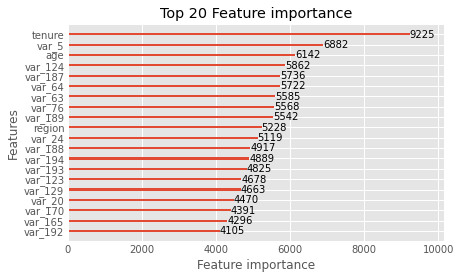

In [67]:
lgb.plot_importance(lgb_model_N_tuned, max_num_features = 20, title= 'Top 20 Feature importance');

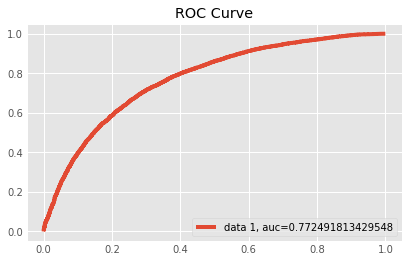

In [68]:
fpr, tpr, _ = roc_curve(y_test,  preds_N_tuned)
auc = roc_auc_score(y_test, preds_N_tuned)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.show()

In [69]:
np.round(preds_N_tuned)
# round to get binary array of predictions

array([1., 1., 1., ..., 1., 1., 1.])

In [70]:
f1_score(y_test,np.round(preds_N_tuned))

0.7937556006225533